<image src='ml-data/pipelines.png'>

problem of predict housing prices will be :
- multivariate regression
- plain batch learning -> since it is small enough to fit in memory
- performace measure -> will be a RMSE

<image src='ml-data/rmse_and_mae.png'>

In [22]:
import os
import tarfile
import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [23]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

In [24]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [25]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [26]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


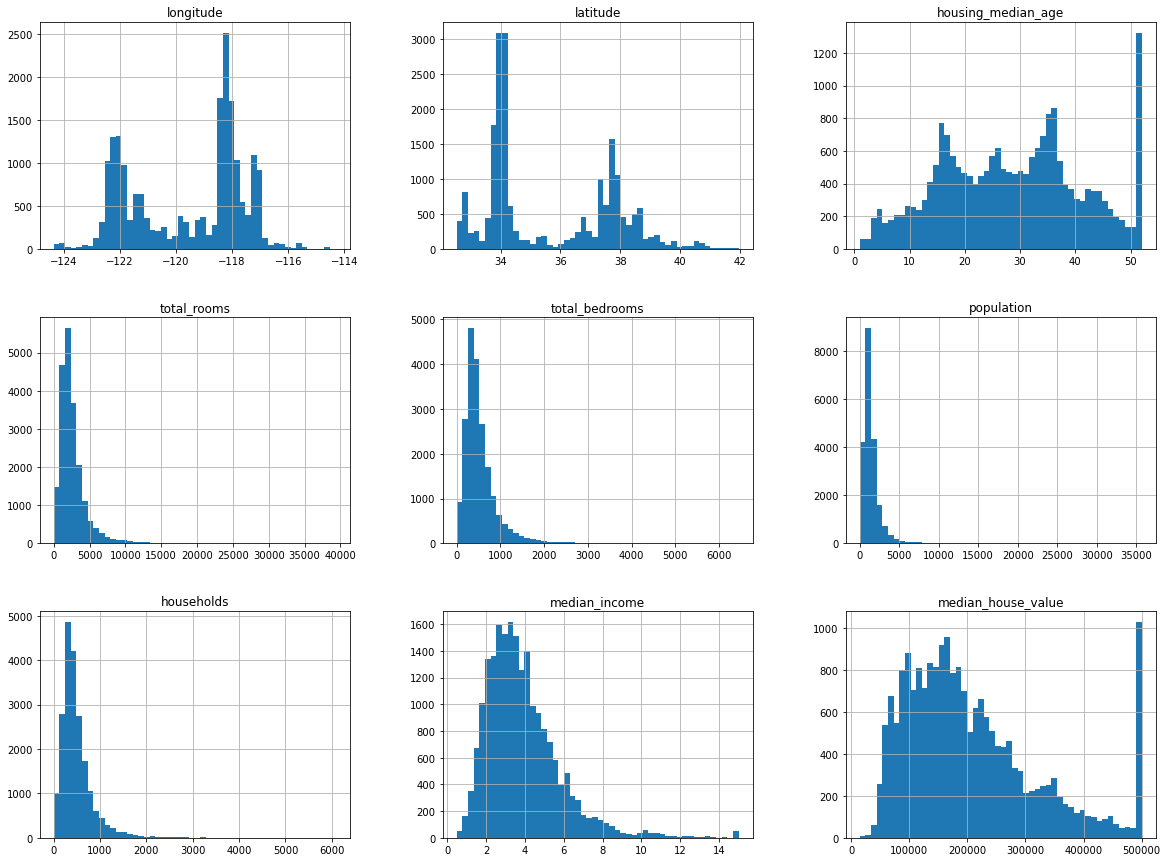

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [28]:
# Split data
import numpy as np
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set=split_train_test(housing,0.2)
len(train_set),len(test_set)

(16512, 4128)

In [29]:
# check hash for test set
from zlib import crc32

def test_set_check(identifier,test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
        ids = data[id_column]
        in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
        return data.loc[~in_test_set], data.loc[in_test_set]   
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
# make sure that new data
#gets appended to the end of the dataset and that no row ever gets deleted

In [30]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [31]:
# from sklearn.model_selection import train_test_split
# train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42,stratify=housing['income_cat'])
# #Same as mine

In [33]:
# test_set["income_cat"].value_counts() / len(test_set)

<AxesSubplot:>

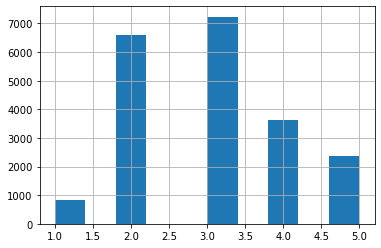

In [34]:
housing["income_cat"] = pd.cut(housing["median_income"],
 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
 labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

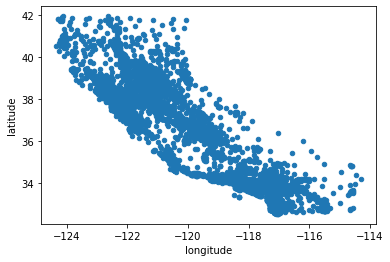

In [35]:
#A geographical scatterplot of the data
%matplotlib inline
housing.plot(kind='scatter',x='longitude',y='latitude')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

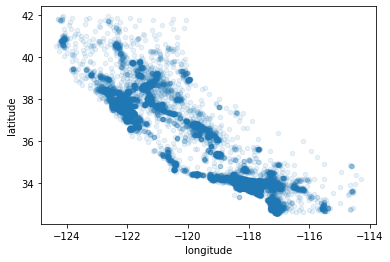

In [36]:
#high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

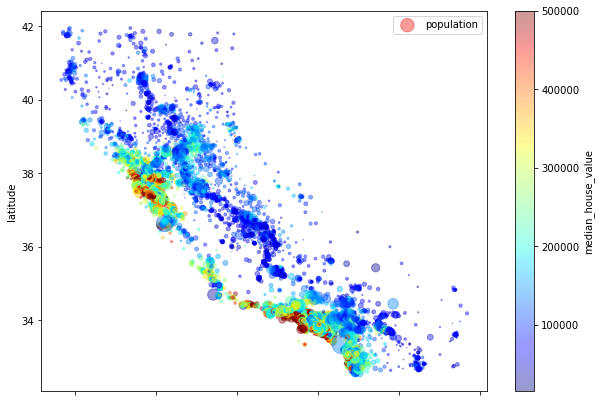

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
#  the housing prices are very much related to the location (e.g., close to the ocean) and to the population density

In [38]:
#first way to check correlation
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

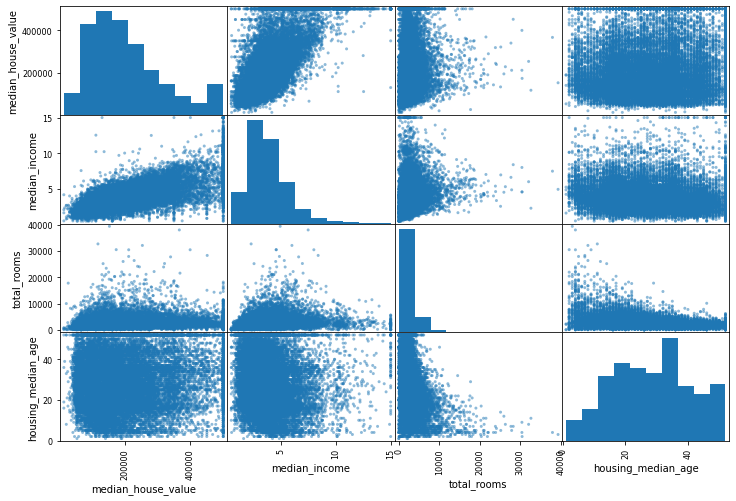

In [39]:
#second way to check correlation
from pandas.plotting import scatter_matrix
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes],figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

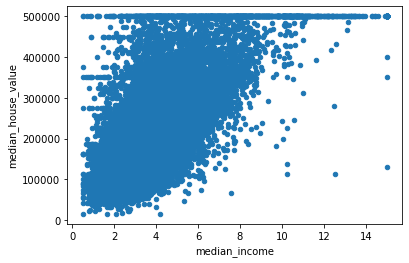

In [40]:
#from above plot The most promising attribute to 
# predict the median house value is the median income
housing.plot(kind='scatter',x='median_income',y='median_house_value')
#there are a data quirks at 500,450,350 which we should remove it

# Attributes combinations

In [41]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)
#Apparently houses with a lower bedroom/room ratio tend to be more expensive

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

# prepare data for ML Algorithms

In [42]:
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)

# Data clenaing

In [43]:
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [44]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop('ocean_proximity',axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

<image src='ml-data/scikit_learn_design1.png'>
<image src='ml-data/scikit_learn_design2.png'>

In [45]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


In [46]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [47]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [48]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

In [49]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [50]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Custom Transformers

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-122.23, 37.88, 41.0, ..., 2.5555555555555554, 6.984126984126984,
        2.5555555555555554],
       [-122.22, 37.86, 21.0, ..., 2.109841827768014, 6.238137082601054,
        2.109841827768014],
       [-122.24, 37.85, 52.0, ..., 2.8022598870056497, 8.288135593220339,
        2.8022598870056497],
       ...,
       [-121.22, 39.43, 17.0, ..., 2.325635103926097, 5.20554272517321,
        2.325635103926097],
       [-121.32, 39.43, 18.0, ..., 2.1232091690544412, 5.329512893982808,
        2.1232091690544412],
       [-121.24, 39.37, 16.0, ..., 2.616981132075472, 5.254716981132075,
        2.616981132075472]], dtype=object)

<image src='ml-data/feature-scaling.png'>

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy="median")),
                ('attribs_adder', CombinedAttributesAdder()),
                ('std_scaler', StandardScaler()),
                ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

# Note
The Pipeline constructor takes a list of name/estimator pairs defining a sequence of
steps. All but the last estimator must be transformers (i.e., they must have a
fit_transform() method).

In [53]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prepared = full_pipeline.fit_transform(housing)

# Note 
The OneHotEncoder returns a sparse matrix, while the num_pipeline returns
a dense matrix. When there is such a mix of sparse and dense matrices, the Colum
nTransformer estimates the density of the final matrix (i.e., the ratio of nonzero
cells), and it returns a sparse matrix if the density is lower than a given threshold (by
default, sparse_threshold=0.3). In this example, it returns a dense matrix. And
that’s it! We have a preprocessing pipeline that takes the full housing data and applies
the appropriate transformations to each column.

In [54]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [55]:
#try model over a few instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [405614. 430896. 381054. 322774. 248082.]
Labels: [452600.0, 358500.0, 352100.0, 341300.0, 342200.0]


In [56]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
# Underfitting since value of error is high in train data

67548.13772600898

# Note for underfitting: 
The main ways to fix underfitting are to select a more
powerful model, to feed the training algorithm with better features, or to reduce the
constraints on the model. This model is not regularized, which rules out the last
option

In [57]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [58]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [59]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
print(scores)
tree_rmse_scores = np.sqrt(-scores)
print(tree_rmse_scores)

[-1.45917208e+10 -5.18334481e+09 -7.06686014e+09 -5.81296452e+09
 -8.14823738e+09 -6.22149409e+09 -4.81053045e+09 -9.78154970e+09
 -8.87933474e+09 -5.17965877e+09]
[120796.19517821  71995.4499567   84064.61884551  76242.79978037
  90267.58762999  78876.44823459  69357.98763483  98901.71736448
  94230.22199527  71969.84625579]


# Train_test_split vs Cross_Validation
<image src='ml-data/cross_validation.png'>

# Note for negative values of scores
<h3>Scikit-Learn’s cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (i.e., a neg‐
ative value), which is why the preceding code computes -scores
before calculating the square root.</h3>

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [120796.19517821  71995.4499567   84064.61884551  76242.79978037
  90267.58762999  78876.44823459  69357.98763483  98901.71736448
  94230.22199527  71969.84625579]
Mean: 85670.28728757324
Standard deviation: 15105.343826057937


# Note that : 
<h3> decision tree is worset than linear regression with score 85509
 and std is about 15100</h3>

In [61]:
# Do cross-validation for linear regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
#Why that ????

Scores: [8.30286146e+04 5.93019397e+04 8.42764597e+04 6.16337206e+04
 2.10185836e+13 6.90422655e+04 5.32743941e+04 8.91946675e+04
 7.63914972e+04 5.53202751e+04]
Mean: 2101858420319.6016
Standard deviation: 6305575050470.861


In [62]:
# Try randomforestregressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [63]:
forest_rmse = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_rmse)
display_scores(forest_rmse_scores)
# random forest is more promising

Scores: [76796.41540752 63820.42697293 61258.9867438  80722.31726516
 62364.96098786]
Mean: 68992.62147545404
Standard deviation: 8111.36916588967


# Save Promising Model 
(hyperparameters and trained parametrers)

In [64]:
import joblib
joblib.dump(forest_reg, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

# Fine tune model
- Grid Search

In [65]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [66]:
grid_search.best_params_,grid_search.best_estimator_

({'max_features': 4, 'n_estimators': 30},
 RandomForestRegressor(max_features=4, n_estimators=30))

# Random Search
<image src='ml-data/random_search.png'>

# Note : Ensemble Methods
<h3>Another way to fine-tune your system is to try to combine the models that perform
best. The group (or “ensemble”) will often perform better than the best individual
model (just like Random Forests perform better than the individual Decision Trees
they rely on)</h3>

In [72]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,<1H OCEAN,5,6.715625,0.156972,2.275000
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,<1H OCEAN,4,7.137809,0.151980,3.021201
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,<1H OCEAN,3,5.283636,0.185822,2.938182
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,<1H OCEAN,3,5.491694,0.196612,3.561462
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,NEAR OCEAN,3,6.154723,0.162477,2.434853
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12182,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,<1H OCEAN,2,6.108696,0.189947,3.279891
7275,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,<1H OCEAN,2,3.138298,0.332203,4.503546
17223,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,<1H OCEAN,4,4.974860,0.192027,1.851955
10786,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,<1H OCEAN,4,5.026699,0.198938,2.623786


In [80]:
strat_test_set['median_house_value']= housing_labels

In [82]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
final_rmse

19806.17906071967

# compute a 95% confidence interval for the generalization error 
<h3>We need to check that if we have a model deployed on production and we try to tune it or replace it , then we must check new model result first</h3>

In [83]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,loc=squared_errors.mean(),scale=stats.sem(squared_errors)))

array([19000.10412082, 20580.70701819])

# There is last section (Launch, Monitor, and Maintain Your System) , you can read and solve exercises
Please give me a feedback, I hope it may help
Reading is a nice thing to do

# End